In [1]:
import torch
import torch.nn as nn

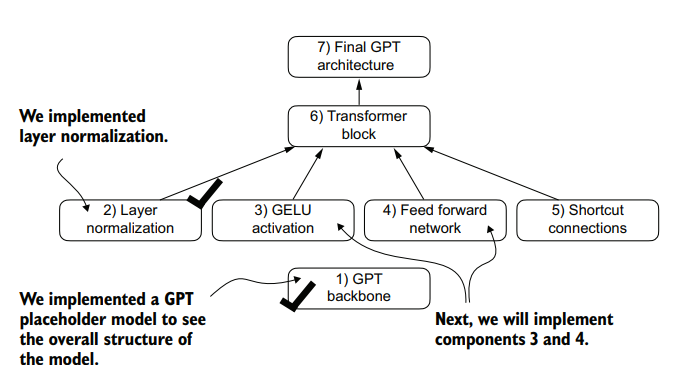

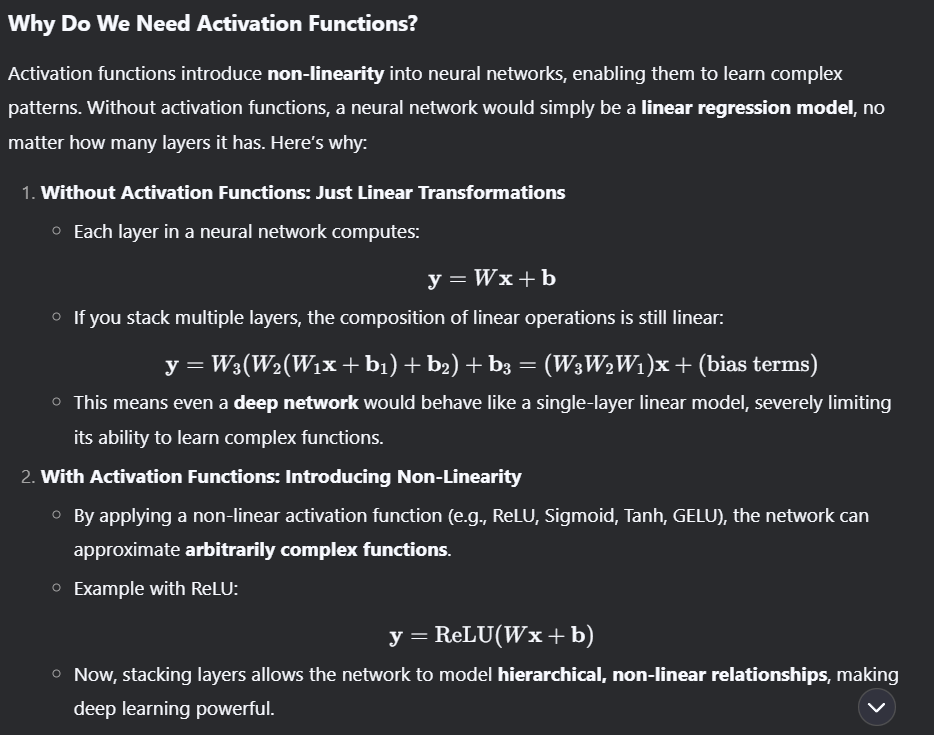

### ReLU (Rectified Linear Units)
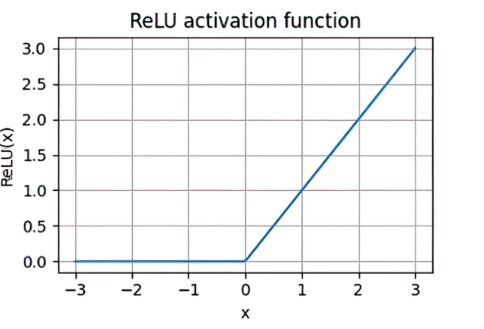

$ReLU(x)=max(0,x)$

1. Simple and faste to compute

2. Solves the vanishing gradient problem

    Earlier activations like sigmoid or tanh squashed values between small ranges (e.g., &$[0,1]$ or $[-1,1]$), which made their derivatives small. This caused gradients to vanish during backpropagation, especially in deep networks.

3. Induces Sparsity
    Since ReLU sets negative activations to zero, many neurons become inactive (output 0). This introduces sparsity in the model, which:

        a. Makes the network more efficient

        b. Encourages feature selection, acting like a kind of regularizer


#### Problems with RELU
1. **"Dying ReLU" Problem**

    If a neuron gets stuck in the negative region (always outputs 0), its gradient becomes zero permanently → the neuron stops learning. The neurons become **dead neurons**

2. **Zero-Hard Threshold is Not Optimal**

    This hard cutoff discards all negative inputs, regardless of how small or informative they might be.

    There's no gradient flow for negative values → information loss.

3. **Bias Toward Positive Activations**

    ReLU outputs are always non-negative, which can lead to a non-zero mean of activations.

    This might slow down convergence and make batch normalization more necessary.

4. **No Probabilistic Interpretation**

    ReLU deterministically outputs 0 or x, with no stochasticity or uncertainty.

    That rigidity limits its flexibility and robustness, especially under adversarial settings or noisy inputs.

### GELU (Gaussian Error Linear Units)
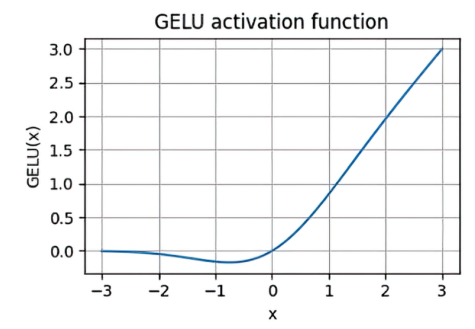
1. **Motivation: Combining ReLU, Dropout, and Zoneout**

    ReLU (Rectified Linear Unit): This activation function outputs zero if the input is negative, and the input itself if it’s positive. It can be interpreted as deterministically multiplying the input by 0 or 1, depending on whether it's negative or positive.

    Dropout: A regularization method that randomly sets a fraction of activations to zero during training. This can be interpreted as stochastically multiplying the input by 0 or 1.

    Zoneout: A technique often used in RNNs (Krueger et al., 2016) where some neuron states are randomly preserved (multiplied by 1) during training rather than updated (which would correspond to multiplying by 0 and adding a new value).

    The GELU function aims to merge these ideas:

    Like ReLU, it uses a "zero-one mask" to determine whether to pass or block the input.

    Like dropout and zoneout, this masking is stochastic, introducing randomness.

    However, unlike dropout, the randomness is not uniform. Instead, it's input-dependent.

2. **Mathematical Formulation of GELU**

    GELU introduces the idea of multiplying the input $x$ by a Bernoulli random variable $m$, where the probability of $m = 1$ is not fixed but depends on $x$.

    Specifically,

    m ~ Bernoulli $(\Phi(x))$

    Where,

    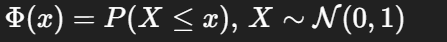

    is the cummulative distribution function (CDF) of the **standard normal distribution**.

    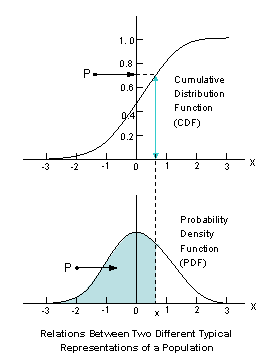

3. **Why Use the Normal CDF?**

    Neuron inputs tend to follow a normal distribution (especially when using Batch Normalization).

    By using the standard normal CDF $\Phi(x)$, the transformation naturally aligns with this distribution.

    The function becomes a smooth approximation of a stochastic process where each input value has a probabilistic chance of being zeroed or passed, depending on its magnitude.

4. **But why CDF specifically?**

    It has these critical properties:

    As $x → -\inf$, $\Phi(x) → 0$

    As $x → \inf, \Phi(x) → 1$

    It's monotonic, differentiable, and smoothly increasing

    At $x = 0, \Phi(0) = 0.5$ → nicely centered

    This makes it ideal for smoothly gating the input x between being dropped (0) and passed (1), in a probabilistic yet input-sensitive manner.

    Whereas ReLU just cuts off and abruptly drops the input.


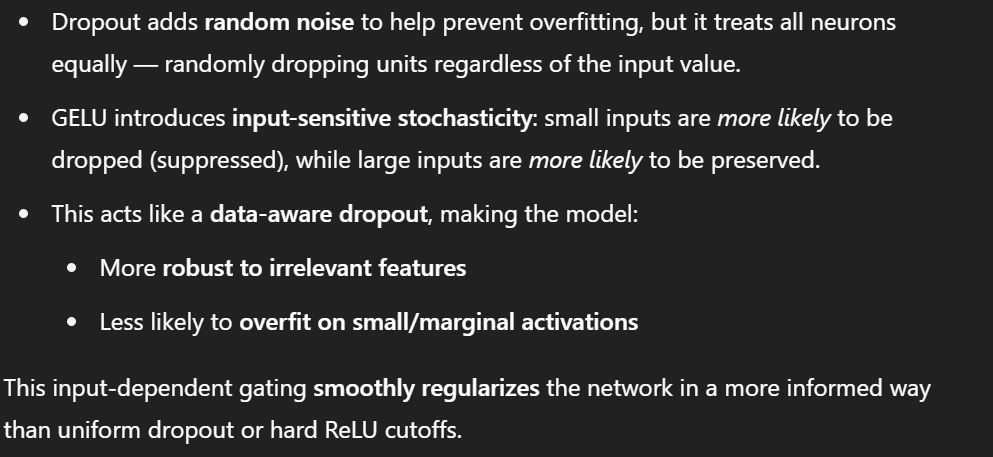

### Implementing feed forward network with GELU

In implementation, we approximate the GELU function with the following equation:

$$
\text{GELU}(x) \approx 0.5x \left[1 + \tanh\left(\sqrt{\frac{2}{\pi}} \left(x + 0.044715x^3\right)\right)\right]
$$
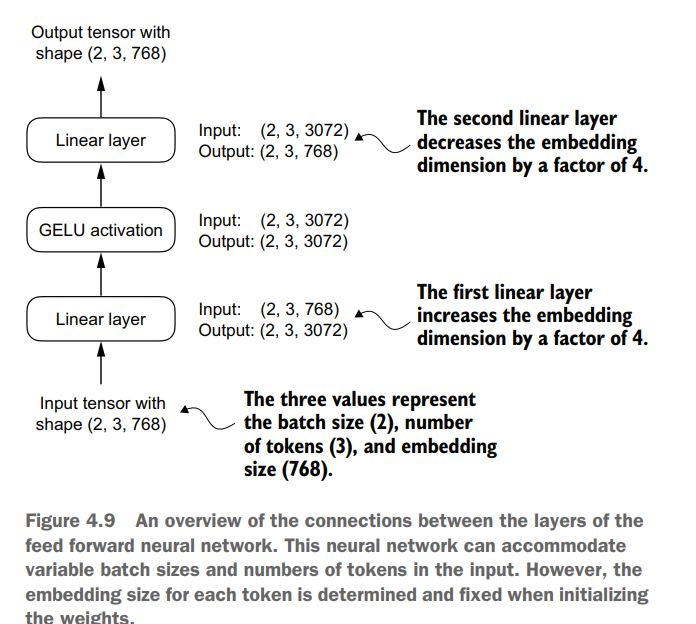

In [4]:
class GELU(nn.Module):
    def __init__(self):

        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0/torch.pi)) * (x + 0.044715 * torch.pow(x, 3))
        ))

The `FeedForward` module plays a crucial role in enhancing the model’s ability to learn
from and generalize the data. Although the input and output dimensions of this
module are the same, it internally expands the embedding dimension into a higher dimensional space through the first linear layer, as illustrated in figure: 

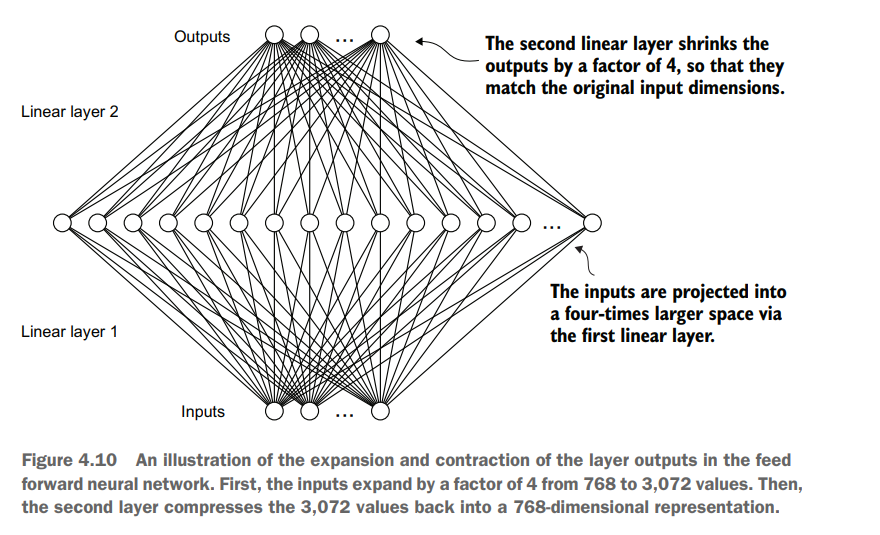

This expansion is followed by a nonlinear GELU activation and then a contraction back to the original dimension with the second linear transformation. Such a design allows for the
exploration of a richer representation space

In [5]:
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(config["emb_dim"], 4 * config["emb_dim"]),
            GELU(),
            nn.Linear(4 * config["emb_dim"], config["emb_dim"]),
        )

    def forward(self, x):

        return self.layers(x)
        # The output shape is (batch_size, seq_len, emb_dim)

In [7]:
GPT_CONFIG_124M = {
 "vocab_size": 50257, # Vocabulary size
 "context_length": 1024, # Context length
 "emb_dim": 768, # Embedding dimension
 "n_heads": 12, # Number of attention heads
 "n_layers": 12, # Number of layers
 "drop_rate": 0.1, # Dropout rate
 "qkv_bias": False # Query-Key-Value bias
}

ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768) 
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


In [8]:
print(x)
print(out)

tensor([[[0.9316, 0.1290, 0.4382,  ..., 0.3407, 0.3058, 0.9376],
         [0.1673, 0.9731, 0.9818,  ..., 0.8809, 0.6087, 0.0597],
         [0.0229, 0.3976, 0.9716,  ..., 0.0063, 0.8802, 0.8325]],

        [[0.6195, 0.9372, 0.7488,  ..., 0.1672, 0.1696, 0.0081],
         [0.7609, 0.2973, 0.6198,  ..., 0.8456, 0.4961, 0.4523],
         [0.5589, 0.2830, 0.5201,  ..., 0.7799, 0.2103, 0.5221]]])
tensor([[[ 0.2011,  0.0411, -0.0104,  ..., -0.0070,  0.0893, -0.0793],
         [ 0.1439,  0.0514, -0.1169,  ...,  0.0626,  0.0647, -0.0369],
         [ 0.1647, -0.0234, -0.1287,  ...,  0.0753,  0.0475,  0.0227]],

        [[ 0.2943,  0.1342, -0.1708,  ...,  0.1288,  0.0983, -0.0067],
         [ 0.1931,  0.0933, -0.0519,  ...,  0.0524,  0.0614, -0.0782],
         [ 0.1341,  0.1053, -0.2064,  ...,  0.1277,  0.0755, -0.0660]]],
       grad_fn=<ViewBackward0>)
